#### CNN's for NLP


* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* dataset: https://github.com/spro/practical-pytorch

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

### Import text-data from txt.files
__Dataset import__

In [2]:
# dataset location: ./dataset/names/*.txt
import glob

all_filenames = glob.glob('dataset/names/*.txt')
print(all_filenames)

['dataset/names/Arabic.txt', 'dataset/names/Chinese.txt', 'dataset/names/Czech.txt', 'dataset/names/Dutch.txt', 'dataset/names/English.txt', 'dataset/names/French.txt', 'dataset/names/German.txt', 'dataset/names/Greek.txt', 'dataset/names/Irish.txt', 'dataset/names/Italian.txt', 'dataset/names/Japanese.txt', 'dataset/names/Korean.txt', 'dataset/names/Polish.txt', 'dataset/names/Portuguese.txt', 'dataset/names/Russian.txt', 'dataset/names/Scottish.txt', 'dataset/names/Spanish.txt', 'dataset/names/Vietnamese.txt']


__Convert to non-ascii characters__

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + "_- .,;'0123456789"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


__Determine categories and words inside each txt file__

In [4]:

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# create a list of words for each category
for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    category_lines[category] = readLines(filename)

n_categories = len(all_categories)
print('n_categories =', n_categories)

# all_categories contains the keys to iterate over the category_lines dict
print(all_categories)

n_categories = 18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


__Creating Tensors__
 
Usually add padding to the character-sequences to normalise length for the CNN input. Avoid this by treating each characters as a 1-hot vector of dimension n_letters.

In [5]:
num_batches = 1 

# every letter in a word should be represented by a vector
def word_to_tensor(word):
    list_of_chars = list(word)
    tensor = torch.zeros(1, num_batches, n_letters)
    tensors = []
    
    # each tensor is a single vector with a 1 for every bigram appearing
    for index, letter in enumerate(list_of_chars):
        letter_index = all_letters.find(letter)
        tensor[0][0][letter_index] = 1
        tensors.append(tensor)
    return tensors


In [6]:
word_to_tensor('test_word')

[
 (0 ,.,.) = 
 
 Columns 0 to 18 
     0   0   0   1   1   0   0   0   0   0   0   0   0   0   1   0   0   1   1
 
 Columns 19 to 37 
     1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 
 Columns 38 to 56 
     0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
 
 Columns 57 to 68 
     0   0   0   0   0   0   0   0   0   0   0   0
 [torch.FloatTensor of size 1x1x69], 
 (0 ,.,.) = 
 
 Columns 0 to 18 
     0   0   0   1   1   0   0   0   0   0   0   0   0   0   1   0   0   1   1
 
 Columns 19 to 37 
     1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 
 Columns 38 to 56 
     0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
 
 Columns 57 to 68 
     0   0   0   0   0   0   0   0   0   0   0   0
 [torch.FloatTensor of size 1x1x69], 
 (0 ,.,.) = 
 
 Columns 0 to 18 
     0   0   0   1   1   0   0   0   0   0   0   0   0   0   1   0   0   1   1
 
 Columns 19 to 37 
     1   0   0   1   

In [7]:
# the X input is a list of all tensors, representing all names
x_input = []
for category in all_categories:
    for name in category_lines[category]:
        x_input.append(word_to_tensor(name))

# the Y labels are the categories, where arabic is 0 and vietnamese is 17
y_input = []
for idx, category in enumerate(all_categories):
    for i in range(0, len(category_lines[category])):
        y_input.append(idx)
        

In [8]:
data = []

for idx, _ in enumerate(x_input):
    data.append([x_input[idx], y_input[idx]])
    
from random import shuffle
shuffle(data)


In [9]:
import pandas as pd

dataframe = {
    'Label' : [data[i][1] for i in range(10)],
    'Size of tensors': [tensor[0].size() for tensor in x_input[9000:9010]]
}

pd.DataFrame(dataframe)

,Label,Size of tensors
0,14,"(1, 1, 69)"
1,4,"(1, 1, 69)"
2,14,"(1, 1, 69)"
3,16,"(1, 1, 69)"
4,4,"(1, 1, 69)"
5,2,"(1, 1, 69)"
6,14,"(1, 1, 69)"
7,14,"(1, 1, 69)"
8,0,"(1, 1, 69)"
9,4,"(1, 1, 69)"


#### CNN model
* 2 convolutional layers
* 2 pooling

In [10]:
class CNN(nn.Module):
    def __init__(self, input_ch, conv1_ch, output_ch, kernel_size, fc_dim, output_size):
        super(CNN, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=input_ch, out_channels=conv1_ch, kernel_size=kernel_size, stride=1,padding=2)
        self.activation1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution2
        self.cnn2 = nn.Conv2d(in_channels=conv1_ch, out_channels=output_ch, kernel_size=kernel_size, stride=1,padding=2)
        self.activation2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 
        self.fc = nn.Linear(1216, output_size)
        
        
    def forward(self, x):
        # 3D tensor to 4D for the conv layer:
        x = x.unsqueeze(0)
        x = self.cnn1(x)
        x = self.activation1(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.activation2(x)
        x = self.maxpool2(x)
        # Resize
        # - original size: [wordlength - 1, batch_size, possible_bigrams: 69]
        # - x.size
        # - new output size: [wordlength - 1, batch_size, possible_bigrams: 69]
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [11]:
(n_letters - 2)/1 +1

68.0

__Kernel size__
* $O = \frac{W-K+2P}{S}+1$
  * $O$: output heigth/length
  * $W$: input height/length
  * $K$: kernel size
  * $P$: padding
    * $ P = \frac{K-1}{2}$
  * $S$: Stride
* $O$ = len(word_to_bigrams)

In [12]:
# input_ch = 1
# conv1_ch = 16
# output_ch, = 32
# kernel_size = 2 to 5
# fc_dim = 1
# output_size = 18 classes
### non-sliding kernel_height = 4761 (possible_bigrams)
### sliding could be e.g. 529 (possible_bigrams/9)
model = CNN(1,16,32,2,1,18)
if torch.cuda.is_available():
    model.cuda()

In [13]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.01
momentum = 0.9


#define loss and optimizer

criterion = nn.CrossEntropyLoss() #cross entropy loss = log softmax + NLL loss
optimizer = optim.Adam(model.parameters())

In [14]:
#for plotting

plot_loss = []
plot_correct = []

In [15]:
# Considering a cuda model, otherwise remove .cpu() or write if/else 
'''
print(model.parameters())
print(len(list(model.parameters())))
print('Conv1 kernels:\n',list(model.parameters())[0].size())
print('Conv1 bias kernels:\n',list(model.parameters())[1].size())
print('Conv2 kernels (depth 16):\n',list(model.parameters())[2].size())
print('Conv2 bias kernels:\n',list(model.parameters())[3].size())
print('Fully connected layer:\n',list(model.parameters())[4].size())
print('Fully connected bias:\n',list(model.parameters())[5].size())'''


"\nprint(model.parameters())\nprint(len(list(model.parameters())))\nprint('Conv1 kernels:\n',list(model.parameters())[0].size())\nprint('Conv1 bias kernels:\n',list(model.parameters())[1].size())\nprint('Conv2 kernels (depth 16):\n',list(model.parameters())[2].size())\nprint('Conv2 bias kernels:\n',list(model.parameters())[3].size())\nprint('Fully connected layer:\n',list(model.parameters())[4].size())\nprint('Fully connected bias:\n',list(model.parameters())[5].size())"

In [16]:
def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # reset gradient
    optimizer.zero_grad()

    # forward pass
    fx = model.forward(x)
    
    # get the loss
    loss = criterion(fx, y)

    # backward pass
    loss.backward()

    # update parameters
    optimizer.step()

    # return the actual loss data, not the Variable
    return loss.data[0]

In [17]:
iter = 0 

for e in range(1, epochs+1):
    loss = 0.
    for i, tensor in enumerate(data):

        x = data[i][0][0].cuda() #converts list of indices to tensor of indices
        y = torch.LongTensor([data[i][1]]).cuda()
        
        loss += train(model, criterion, optimizer, x, y)
    plot_loss.append(loss/len(data))
    print("Epoch %02d, loss = %f" % (e, loss / len(data)))

Epoch 01, loss = 1.262164
Epoch 02, loss = 1.100251
Epoch 03, loss = 1.071740
Epoch 04, loss = 1.054534
Epoch 05, loss = 1.042647
Epoch 06, loss = 1.034538
Epoch 07, loss = 1.028377
Epoch 08, loss = 1.023641
Epoch 09, loss = 1.019815
Epoch 10, loss = 1.017065


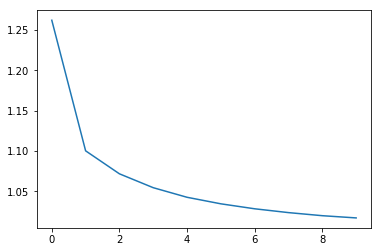

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(plot_loss)

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    return model(line_tensor)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
list_of_lines = [li for li in category_lines.values()]
[line for line in list_of_lines[17]]

In [ ]:
[line[0][:][0] for cat, line in enumerate(category_lines.values())]

In [ ]:
28*28*2